# Chapter 8 - State Space Models and Markov Switching Models

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PythonTsa.RandomWalk import RandomWalk_with_drift
from PythonTsa.plot_acf_pacf import acf_pacf_fig
import statsmodels.api as sm
from PythonTsa.LjungBoxtest import plot_LB_pvalue
from PythonTsa.plot_multi_ACF import multi_ACFfig
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds, ogap, inf
from statsmodels.tsa.regime_switching.tests.test_markov_regression import areturns

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Local-level Model or Random Walk Plus Noise Model

In [6]:
# Set a fixed random seed
np.random.seed(1379)

# Generate a random walk process with zero drift
rw0 = RandomWalk_with_drift(drift=0.0,   # No drift in the random walk
                            nsample=300, # Generate 300 observations
                            burnin=10)   # Discard the first 10 observations

# Generate white noise with mean 0 and standard deviation 2
wn = np.random.normal(loc=0, scale=2.0, size=300)

# Combine the random walk with the white noise
y = rw0 + wn  

In [7]:
y

0      -3.685501
1      -4.336129
2      -1.671062
3      -2.848481
4      -4.165989
         ...    
295     9.507878
296    10.756588
297    11.615473
298    16.439735
299    16.108727
Length: 300, dtype: float64

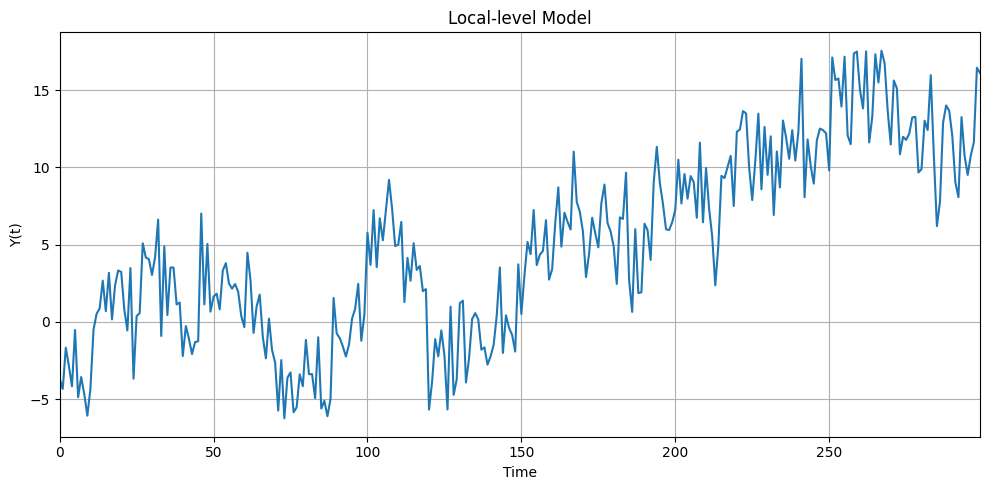

In [8]:
# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Local-level Model')
plt.grid(True)
plt.xlim(0, 299)
plt.tight_layout()
plt.show()

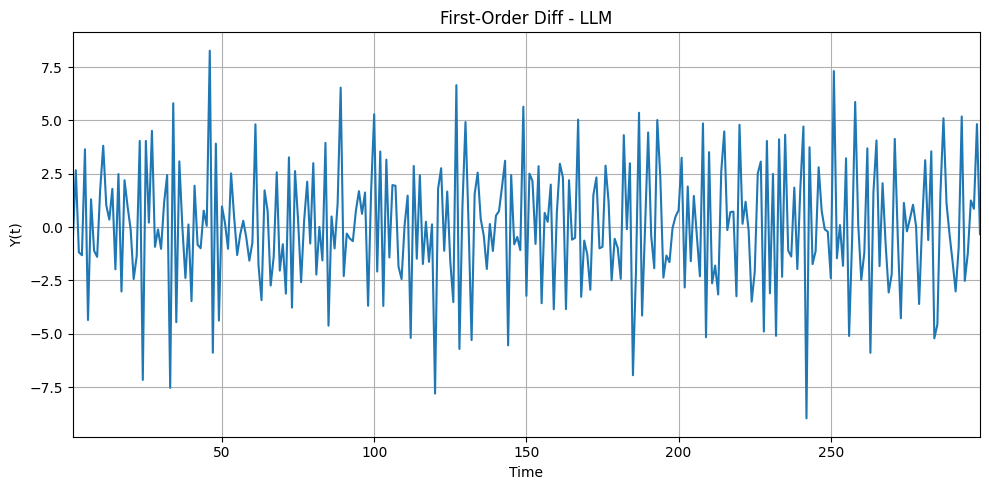

In [9]:
dy = y.diff().dropna()

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(dy)
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('First-Order Diff - LLM')
plt.grid(True)
plt.xlim(1, 299)
plt.tight_layout()
plt.show()

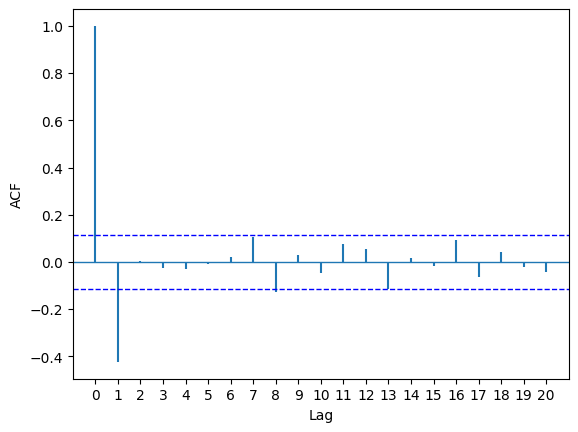

In [10]:
# Plot the ACF (Autocorrelation Function) for the differenced series 'dy'
acf_pacf_fig(dy,         # The differenced time series data
             both=False, # Only plot the ACF (exclude PACF)
             lag=20)     # Compute autocorrelations up to 20 lags

## SARIMAX Models

In [12]:
url2 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_EconUS/USEconomicChange.csv')

uscc = pd.read_csv(url2)

uscc.head()

,Time,Consumption,Income,Production,Savings,Unemployment
0,1970/3/31,0.615986,0.972261,-2.452700,4.810312,0.9
1,1970/6/30,0.460376,1.169085,-0.551525,7.287992,0.5
2,1970/9/30,0.876791,1.553271,-0.358708,7.289013,0.5
3,1970/12/31,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1971/3/31,1.897371,1.987154,1.909734,3.657771,-0.1


In [13]:
dates = pd.date_range('1970/3/31', periods = len(uscc), freq = 'QE')

uscc.index = dates

uscc = uscc.drop(columns = ['Time'])

uscc.rename(columns = {'Consumption':'cons', 'Income':'inc', 'Production':'prod', 'Savings':'sav', 'Unemployment':'unem'}, inplace = True)

uscc

,cons,inc,prod,sav,unem
1970-03-31,0.615986,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.987154,1.909734,3.657771,-0.1
...,...,...,...,...,...
2015-09-30,0.664970,0.801663,0.380606,3.180930,-0.3
2015-12-31,0.561680,0.740063,-0.845546,3.482786,0.0
2016-03-31,0.404682,0.519025,-0.417930,2.236534,0.0
2016-06-30,1.047707,0.723721,-0.203319,-2.721501,-0.1


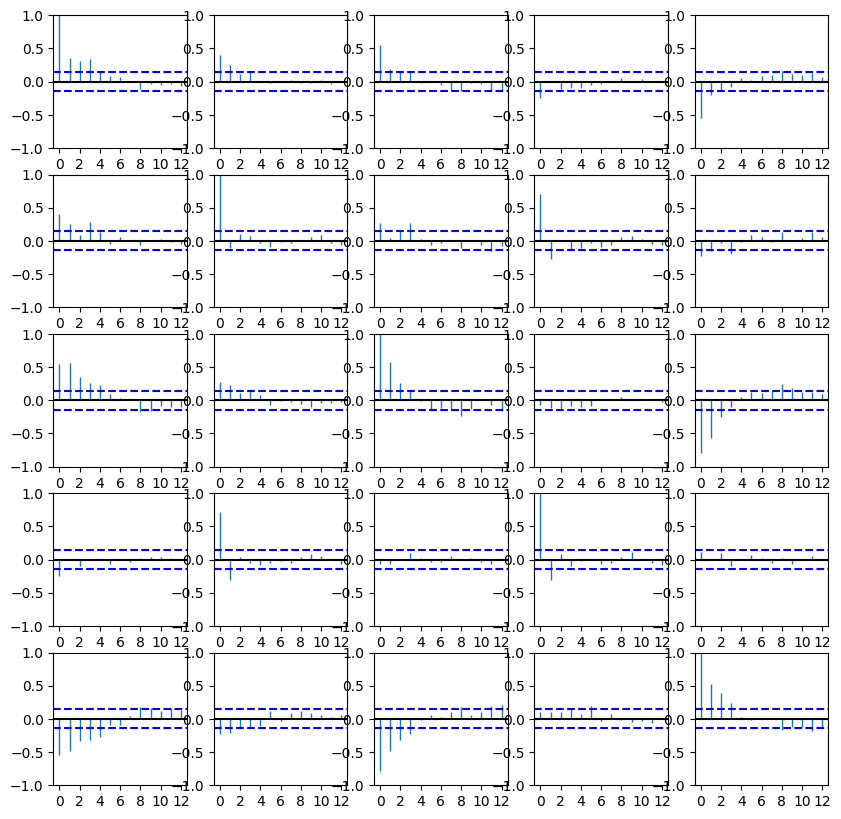

In [14]:
multi_ACFfig(uscc, nlags = 12);

In [15]:
uscc.head()

,cons,inc,prod,sav,unem
1970-03-31,0.615986,0.972261,-2.452700,4.810312,0.9
1970-06-30,0.460376,1.169085,-0.551525,7.287992,0.5
1970-09-30,0.876791,1.553271,-0.358708,7.289013,0.5
1970-12-31,-0.274245,-0.255272,-2.185455,0.985230,0.7
1971-03-31,1.897371,1.987154,1.909734,3.657771,-0.1


In [16]:
# Define independent variables (X) and dependent variable (Y)
X = uscc[['inc', 'prod', 'sav', 'unem']]  # Select predictor variables
Y = uscc['cons']                          # Target variable (consumption)

# Add a constant to the predictor variables
X = sm.add_constant(X, prepend=False)  # Add an intercept term without reordering columns

# Initialize a SARIMAX model with external regressors
sarimaxmod = SARIMAX(endog=Y,          # Dependent variable (consumption)
                     exog=X,           # Explanatory variables (income, production, savings, unemployment)
                     order=(1, 0, 1))  # ARIMA(1,0,1) structure: one autoregressive term, no differencing, one MA term

# Fit the SARIMAX model to the data
sarimaxfit = sarimaxmod.fit(disp=False)  # Disable output during fitting

# Display the summary of the fitted model
print(sarimaxfit.summary()) 

                               SARIMAX Results                                
Dep. Variable:                   cons   No. Observations:                  187
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -52.873
Date:                Tue, 11 Mar 2025   AIC                            121.746
Time:                        08:59:03   BIC                            147.595
Sample:                    03-31-1970   HQIC                           132.220
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inc            0.7313      0.033     22.148      0.000       0.667       0.796
prod           0.0506      0.027      1.898      0.058      -0.002       0.103
sav           -0.0460      0.002    -23.691      0.0

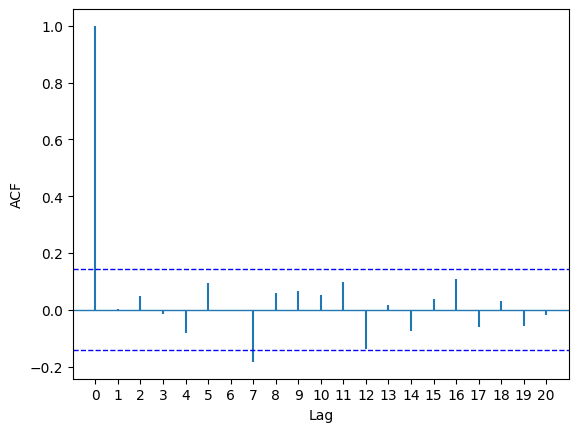

In [17]:
sarimaxresid = sarimaxfit.resid

acf_pacf_fig(sarimaxresid, both = False, lag = 20)

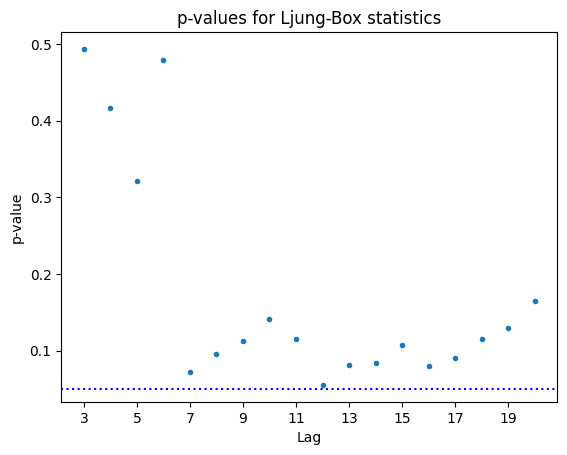

In [18]:
# Plot the Ljung-Box p-values for the SARIMAX residuals to test for autocorrelation
plot_LB_pvalue(sarimaxresid,       # Residuals from the fitted SARIMAX model
               noestimatedcoef=2,  # Number of estimated coefficients (AR and MA terms)
               nolags=20)          # Number of lags to test for autocorrelation

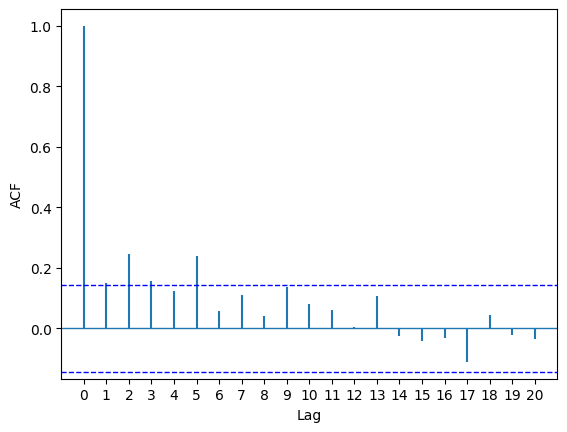

In [19]:
acf_pacf_fig(sarimaxresid**2, both = False, lag = 20)

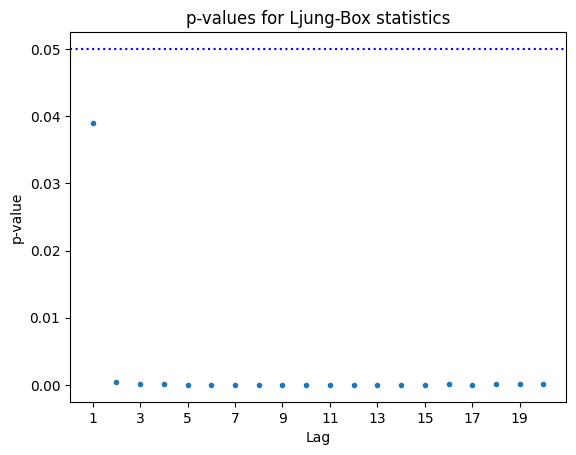

In [20]:
# Plot the Ljung-Box p-values for the squared SARIMAX residuals 
# to test for autocorrelation in variance (possible ARCH effects)
plot_LB_pvalue(sarimaxresid**2,   # Squared residuals from the fitted SARIMAX model
               noestimatedcoef=0, # No estimated coefficients considered in the test
               nolags=20)         # Number of lags to test for autocorrelation in variance

In [21]:
# Fit an ARCH model to the residuals of the SARIMAX model
archmod = arch_model(sarimaxresid,  # Residuals from the SARIMAX model
                     mean='Zero').fit(disp='off')  # Assume zero mean (no mean equation in GARCH models) and suppress output

# Display the summary of the fitted ARCH model
print(archmod.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.005
Vol Model:                      GARCH   Log-Likelihood:               -35.8494
Distribution:                  Normal   AIC:                           77.6988
Method:            Maximum Likelihood   BIC:                           87.3921
                                        No. Observations:                  187
Date:                Tue, Mar 11 2025   Df Residuals:                      187
Time:                        08:59:03   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.0515e-03  3.711e-03      1.092      0.275 

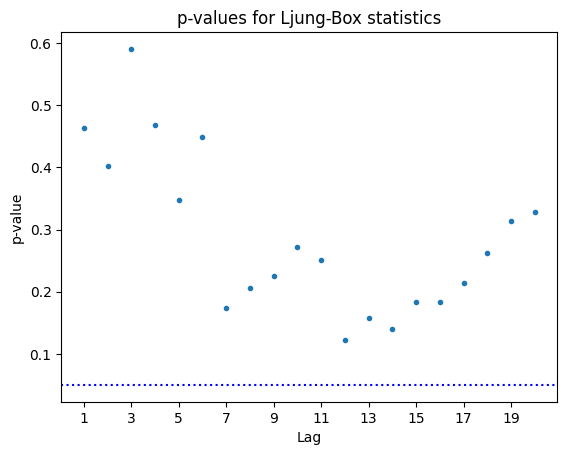

In [22]:
# Extract standardized residuals from the fitted ARCH model
archresid = archmod.std_resid     # Standardized residuals (residuals divided by estimated volatility)

# Plot the Ljung-Box p-values for the standardized residuals 
# to check for remaining autocorrelation
plot_LB_pvalue(archresid,         # Standardized residuals from the ARCH model
               noestimatedcoef=0, # No estimated coefficients considered in the test
               nolags=20)         # Number of lags to test for autocorrelation

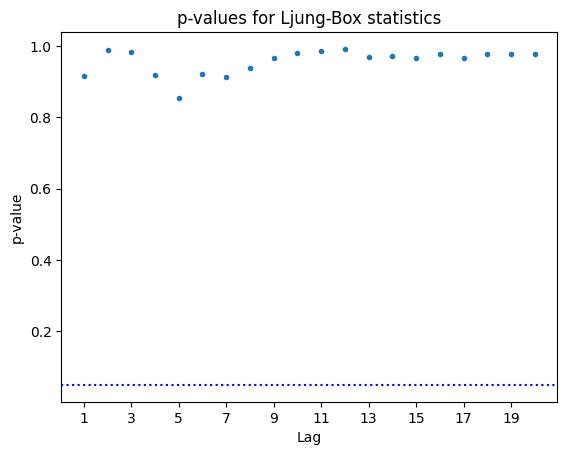

In [23]:
# Plot the Ljung-Box p-values for the squared standardized residuals 
# to test for autocorrelation in variance (presence of ARCH effects)
plot_LB_pvalue(archresid**2,      # Squared standardized residuals from the ARCH model
               noestimatedcoef=0, # No estimated coefficients considered in the test
               nolags=20)         # Number of lags to test for autocorrelation in variance

# Markov Switching Models

### Log Returns of Germany DAX Daily Index

In [26]:
url4 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_MarkovReturnsDAX/DAXlogret.csv')

daxlogret = pd.read_csv(url4, header = 0)

daxlogret.head()

,Date,Logret
0,2014/10/24,-0.002379
1,2014/10/27,-0.006452
2,2014/10/28,0.019075
3,2014/10/29,0.006253
4,2014/10/30,-0.010968


In [27]:
daxlogret.index = pd.DatetimeIndex(daxlogret.Date)

daxlogret.head()

,Date,Logret
Date,,
2014-10-24,2014/10/24,-0.002379
2014-10-27,2014/10/27,-0.006452
2014-10-28,2014/10/28,0.019075
2014-10-29,2014/10/29,0.006253
2014-10-30,2014/10/30,-0.010968


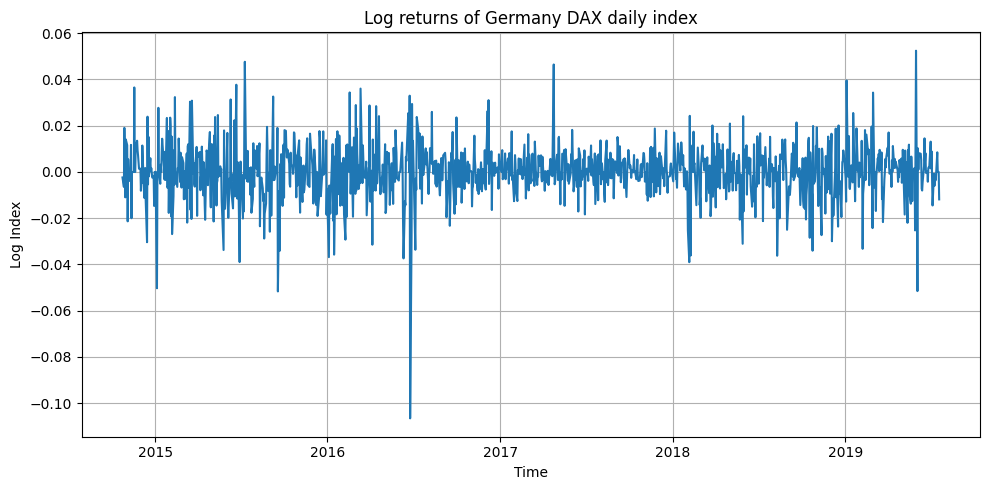

In [28]:
logret = daxlogret.Logret

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(logret)
plt.xlabel('Time')
plt.ylabel('Log Index')
plt.title('Log returns of Germany DAX daily index')
plt.grid(True)
#plt.xlim(0, 299)
plt.tight_layout()
plt.show()

In [29]:
# Define a Markov-switching autoregressive model (MS-AR) with regime-dependent variance
mod = sm.tsa.MarkovAutoregression(logret,                   # Time series data (log returns)
                                  k_regimes=2,              # Number of regimes (two regimes)
                                  order=1,                  # Autoregressive order (AR(1))
                                  switching_variance=True)  # Allow variance to switch between regimes

# Fit the Markov-switching autoregressive model
modfit = mod.fit()  # Estimate parameters using Maximum Likelihood Estimation (MLE)

# Display the summary
print(modfit.summary())

                         Markov Switching Model Results                         
Dep. Variable:                   Logret   No. Observations:                 1190
Model:             MarkovAutoregression   Log Likelihood                3692.208
Date:                  Tue, 11 Mar 2025   AIC                          -7368.417
Time:                          08:59:05   BIC                          -7327.763
Sample:                               0   HQIC                         -7353.096
                                 - 1190                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.643      0.008       0.000       0.001
sigma2      5.438e-05   5.55e-06    

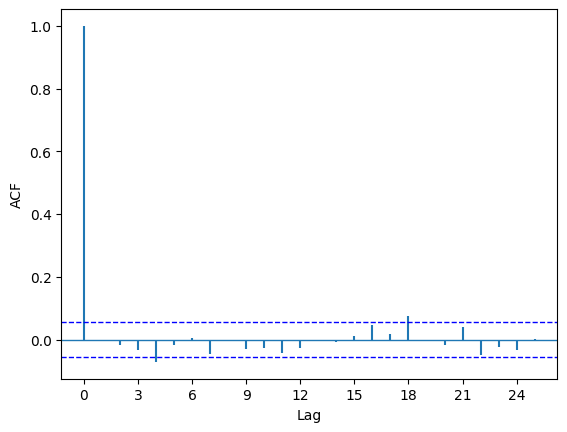

In [30]:
# Extract residuals from the fitted Markov-switching autoregressive model
modresid = modfit.resid   # Residuals of the MS-AR model

# Plot the ACF (Autocorrelation Function) for the residuals 
# to check for remaining autocorrelation
acf_pacf_fig(modresid,    # Residuals from the Markov-switching model
             both=False,  # Only plot the ACF (exclude PACF)
             lag=25)      # Compute autocorrelations up to 25 lags

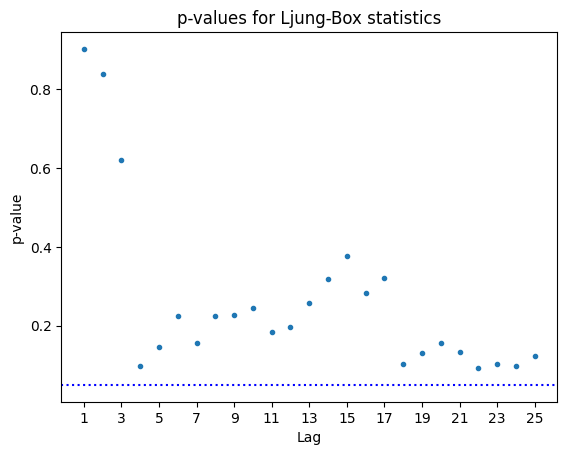

In [31]:
# Plot the Ljung-Box p-values for the residuals of the Markov-switching model
plot_LB_pvalue(modresid,          # Residuals from the fitted Markov-switching model
               noestimatedcoef=0, # No estimated coefficients considered in the test
               nolags=25)         # Number of lags to test for autocorrelation

### Federal Funds Rate, Output Gap, and Inflation Rate

In [33]:
index = pd.date_range('1954-07-01', '2010-10-01', freq = 'QS')
dta_fedfunds  =  pd.Series(fedfunds, index = index)
dta_ogap  =  pd.Series(ogap, index = index)
dta_inf  =  pd.Series(inf, index = index)

dta_inf.head()

1954-07-01         NaN
1954-10-01         NaN
1955-01-01         NaN
1955-04-01         NaN
1955-07-01   -0.234724
Freq: QS-JAN, dtype: float64

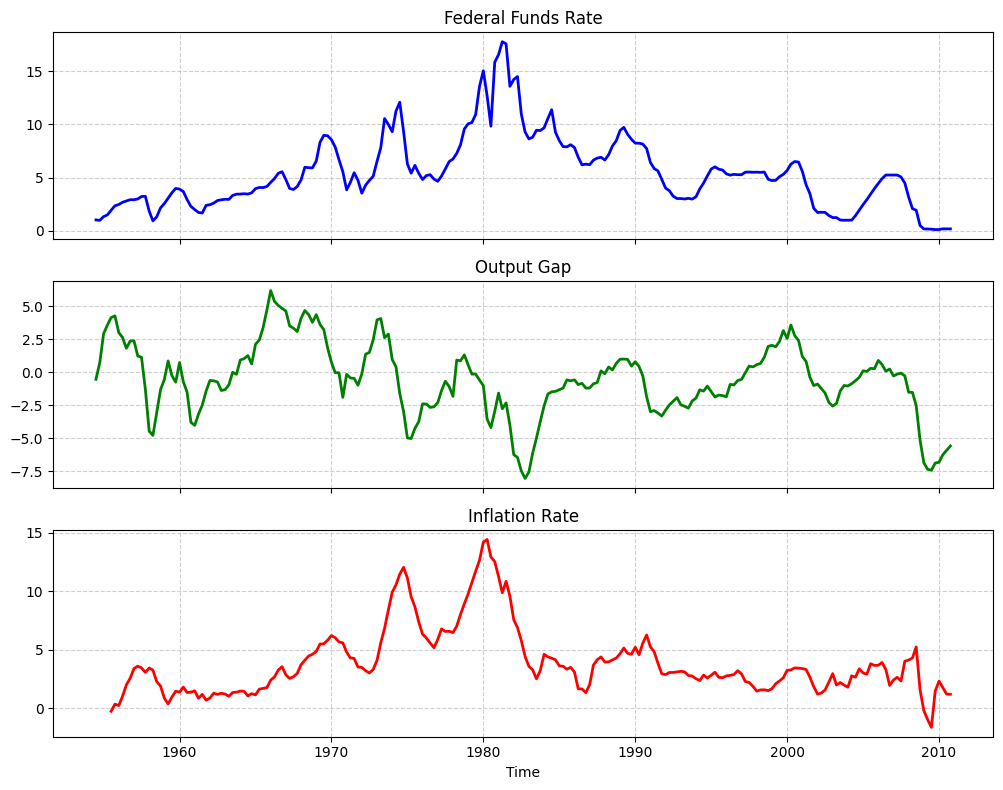

In [34]:
# Visualization of the Federal Funds Rate, Output Gap, and Inflation Rate
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot Federal Funds Rate
axes[0].plot(dta_fedfunds, color='blue', linewidth=2)
axes[0].set_title("Federal Funds Rate", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Plot Output Gap
axes[1].plot(dta_ogap, color='green', linewidth=2)
axes[1].set_title("Output Gap", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)

# Plot Inflation Rate
axes[2].plot(dta_inf, color='red', linewidth=2)
axes[2].set_title("Inflation Rate", fontsize=12)
axes[2].set_xlabel("Time")
axes[2].grid(True, linestyle="--", alpha=0.6)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [35]:
# Concatenate 'dta_ogap' (Output Gap) and 'dta_inf' (Inflation Rate) into a single DataFrame and remove the first 4 rows

exog1 = pd.concat((dta_ogap, dta_inf), axis=1).iloc[4:]  # Combine data and remove initial 4 rows

In [36]:
# Define a Markov-switching autoregressive model (MS-AR) for the Federal Funds Rate
mymod_fedfunds = sm.tsa.MarkovAutoregression(dta_fedfunds.iloc[4:],  # Target variable (Federal Funds Rate, removing first 4 rows)
                                             k_regimes=2,            # Number of regimes (two-state switching)
                                             order=4,                # Autoregressive order (AR(4))
                                             exog=exog1)             # Include output gap and inflation rate as exogenous variables

# Fit the Markov-switching autoregressive model
myres_fedfunds = mymod_fedfunds.fit()  # Estimate parameters using Maximum Likelihood Estimation (MLE)

# Display the summary
print(myres_fedfunds.summary())

                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                  218
Model:             MarkovAutoregression   Log Likelihood                -264.575
Date:                  Tue, 11 Mar 2025   AIC                            559.149
Time:                          08:59:14   BIC                            609.917
Sample:                      07-01-1955   HQIC                           579.655
                           - 10-01-2010                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5097      0.289      1.766      0.077      -0.056       1.075
ar.L1          0.1808      0.130    

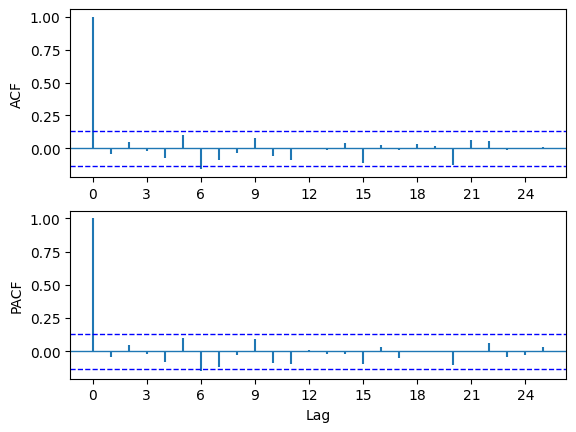

In [37]:
# Extract residuals from the fitted Markov-switching autoregressive model
myresid = myres_fedfunds.resid  

# Plot the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to analyze residual autocorrelation
acf_pacf_fig(myresid,    # Residuals from the MS-AR model
             both=True,  # Plot both ACF and PACF
             lag=25)     # Compute autocorrelations up to 25 lags

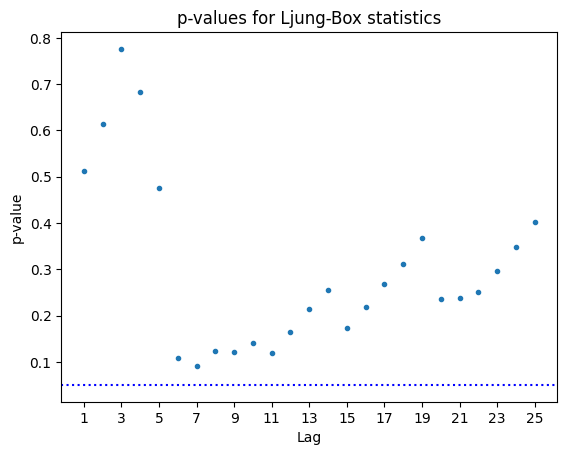

In [38]:
# Perform the Ljung-Box test to check for autocorrelation in the residuals
plot_LB_pvalue(myresid,           # Residuals from the Markov-switching AR model
               noestimatedcoef=0, # No estimated coefficients considered in the test
               nolags=25)         # Number of lags to test for autocorrelation

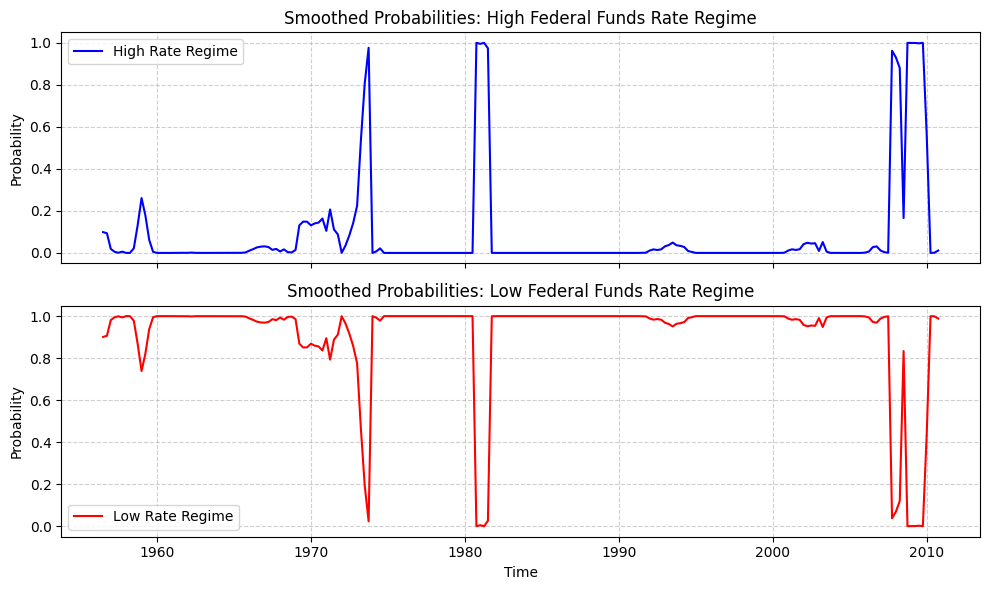

In [39]:
# Create a figure with two subplots for smoothed regime probabilities
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Plot the smoothed probabilities of being in the high federal funds rate regime
axes[0].plot(myres_fedfunds.smoothed_marginal_probabilities[0], color='b', label='High Rate Regime')
axes[0].set_title('Smoothed Probabilities: High Federal Funds Rate Regime', fontsize=12)
axes[0].set_ylabel('Probability')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(loc=2)

# Plot the smoothed probabilities of being in the low federal funds rate regime
axes[1].plot(myres_fedfunds.smoothed_marginal_probabilities[1], color='r', label='Low Rate Regime')
axes[1].set_title('Smoothed Probabilities: Low Federal Funds Rate Regime', fontsize=12)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Probability')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(loc=3)

# Improve layout
plt.tight_layout()
plt.show()

In [40]:
# Expected number of periods in each regime
print(myres_fedfunds.expected_durations)

[ 3.55737378 38.37500431]


`expected_durations` provides the average duration that the system is expected to remain in each regime before switching.
This is useful for analyzing how persistent a high or low federal funds rate regime is.

## Absolute Returns of S&P 500

In [43]:
index = pd.date_range("2004-05-04", "2014-5-03", freq = "W")

dta_areturns  =  pd.Series(areturns, index = index)
dta_areturns

2004-05-09    1.608641
2004-05-16    0.658164
2004-05-23    0.911773
2004-05-30    1.889705
2004-06-06    0.763787
                ...   
2014-03-30    0.442875
2014-04-06    0.345790
2014-04-13    1.484493
2014-04-20    1.959247
2014-04-27    0.097174
Freq: W-SUN, Length: 521, dtype: float64

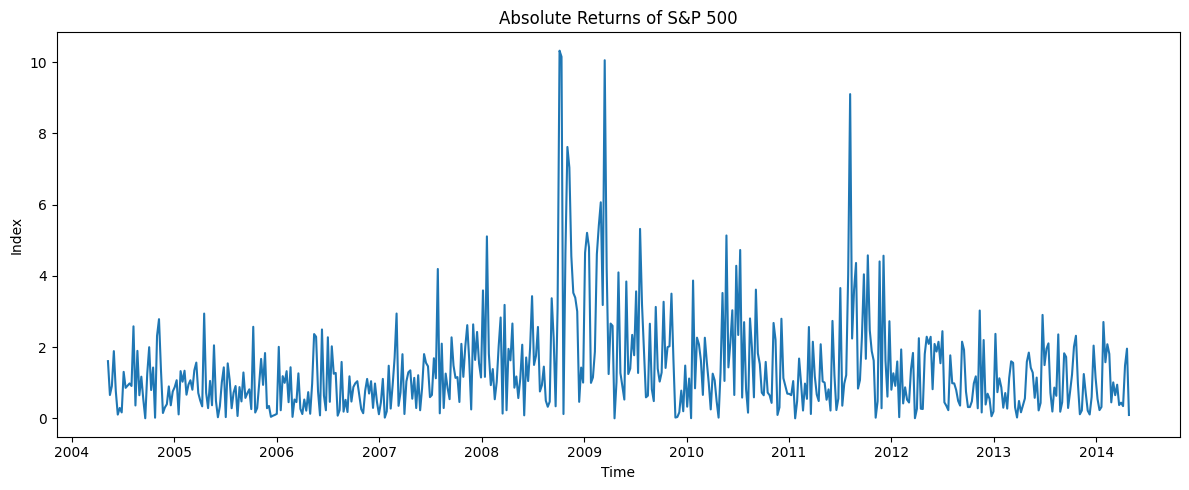

In [44]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(dta_areturns)
plt.xlabel('Time')
plt.ylabel('Index')
plt.title('Absolute Returns of S&P 500')
plt.tight_layout()
plt.show()

In [45]:
# Fit a Markov-switching autoregressive model with two regimes and order 4
myMauto1 = sm.tsa.MarkovAutoregression(dta_areturns,              # Time series data 
                                        k_regimes=2,              # Number of regimes 
                                        order=4,                  # AR order 
                                        switching_variance=True)  # Allow variance to switch between regimes
# Estimate model parameters
myfit1 = myMauto1.fit()

# Print the summary of the fitted model
print(myfit1.summary())

                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                  517
Model:             MarkovAutoregression   Log Likelihood                -740.582
Date:                  Tue, 11 Mar 2025   AIC                           1509.164
Time:                          08:59:31   BIC                           1568.636
Sample:                      05-09-2004   HQIC                          1532.467
                           - 04-27-2014                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0694      0.062     17.153      0.000       0.947       1.192
sigma2         0.6316      0.062    

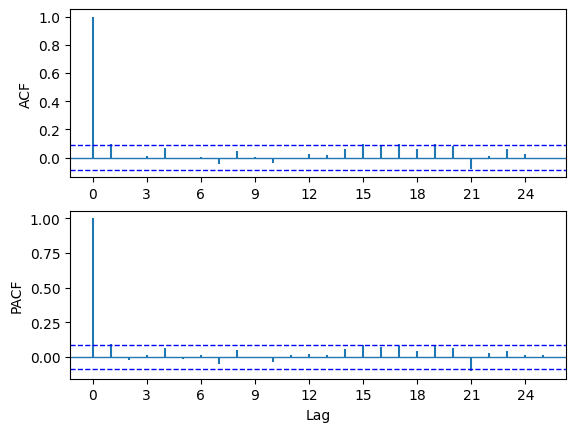

In [46]:
# Extract residuals from the fitted Markov-switching autoregressive model
myresid1 = myfit1.resid  

# Plot the ACF and PACF of the residuals to check for remaining autocorrelation
acf_pacf_fig(myresid1,       # Residuals from the model
             both=True,      # Plot both ACF and PACF
             lag=25)         # Number of lags to display

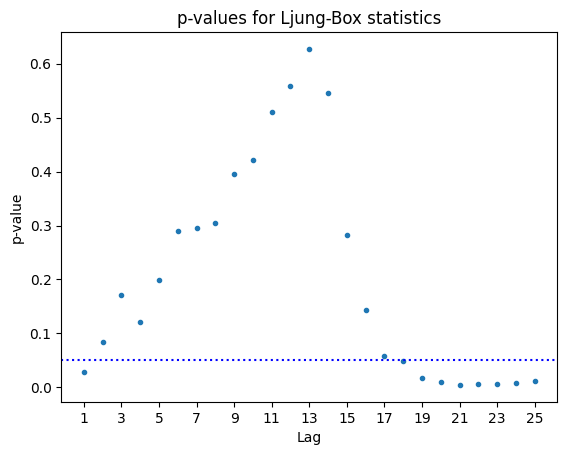

In [47]:
# Perform the Ljung-Box test to check for autocorrelation in residuals
plot_LB_pvalue(myresid1,           # Residuals from the Markov-switching model
               noestimatedcoef=0,  # No estimated coefficients to adjust degrees of freedom
               nolags=25)          # Number of lags for the test

In [48]:
# Take the natural logarithm of the 'dta_areturns' time series
Ldta = np.log(dta_areturns)  

# Define a Markov-switching autoregressive model (MS-AR) with:
myMauto = sm.tsa.MarkovAutoregression(Ldta,                    # Data
                                      k_regimes=2,             # 2 regimes 
                                      order=4,                 # 4th order autoregressive process    
                                      trend='n',               # No trend ('n')
                                      switching_variance=True) # Switching variance between regimes
# Fit the model to the data
myfit = myMauto.fit()

# Print the model summary
print(myfit.summary())  

                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                  517
Model:             MarkovAutoregression   Log Likelihood                -774.828
Date:                  Tue, 11 Mar 2025   AIC                           1573.655
Time:                          08:59:44   BIC                           1624.632
Sample:                      05-09-2004   HQIC                          1593.630
                           - 04-27-2014                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.3165      1.774      3.560      0.000       2.839       9.794
ar.L1          0.5610      0.080    

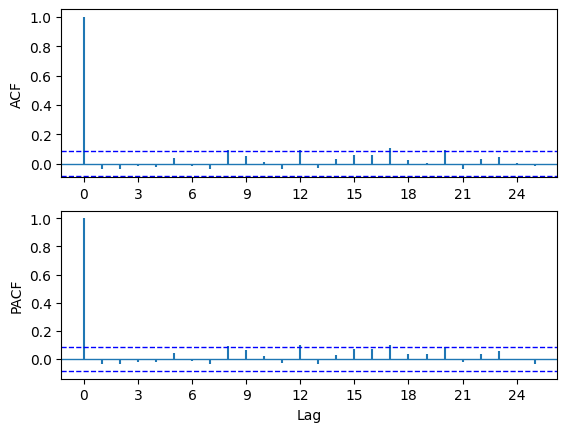

In [49]:
# Extract the residuals from the fitted Markov-switching autoregressive model
myresid = myfit.resid  

# Plot the ACF and PACF of the residuals with:
acf_pacf_fig(myresid,    # Residuals from the fitted model
             both=True,  # Plot both ACF and PACF
             lag=25)     # Set the number of lags to 25

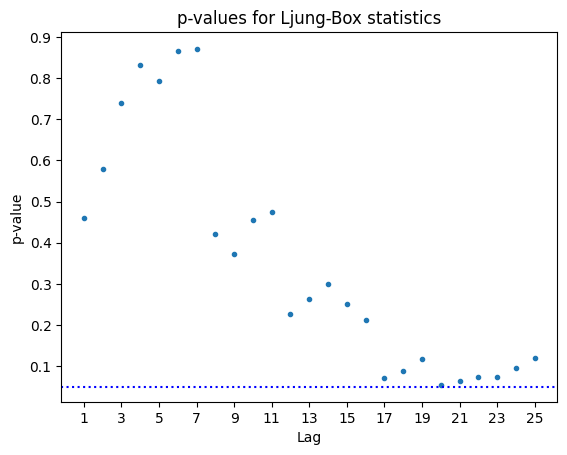

In [50]:
# Plot the Ljung-Box p-values for the residuals of the fitted Markov-switching model
plot_LB_pvalue(myresid,            # Residuals from the fitted model
               noestimatedcoef=0,  # No estimated coefficients (degrees of freedom adjustment)
               nolags=25)          # Number of lags to test autocorrelation up to 25